# Wang-Landau sampling of an FCC anti-ferromagnetic Ising model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pymatgen.core import Structure, Lattice, Composition
import crystal_toolkit
from smol.cofe import ClusterSubspace, ClusterExpansion
from smol.moca import Ensemble, Sampler, SampleContainer

# set kB to 1 in smol for unit-less results
import smol.constants
setattr(smol.constants, "kB", 1.0)

### 1) Create an FCC Ising model
To illustrate how to carry out Wang-Landau sampling we will work with a simple Ising model, however the same procedure can be used for any cluster expansion of arbitrary complexity

In [2]:
# Use dummy + and - species to represent Ising spins
species = {"+": 0.5, "-": 0.5}
prim = Structure.from_spacegroup("Fm-3m", Lattice.cubic(np.sqrt(2)), [species], [[0, 0, 0]])

# create the subspace
subspace = ClusterSubspace.from_cutoffs(prim, {2: 1.1}, basis='chebyshev')
print(subspace)

# create the cluster expansion
h = 2 # external magnetic field value

# coefficients are ECI x multiplicity
# set interaction parameter J = -1
eci = np.array([0.0, h, 1.0])
coefficients = subspace.orbit_multiplicities * eci

ising = ClusterExpansion(subspace, coefficients=coefficients)

Basis/Orthogonal/Orthonormal : chebyshev/True/True
       Unit Cell Composition : +2 -2
            Number of Orbits : 3
No. of Correlation Functions : 3
             Cluster Cutoffs : 2: 1.00
              External Terms : []
Orbit Summary
 ------------------------------------------------------------------------
 |  ID     Degree    Cluster Diameter    Multiplicity    No. Functions  |
 |   0       0             NA                 0                1        |
 |   1       1            0.0000              4                1        |
 |   2       2            1.0000              24               1        |
 ------------------------------------------------------------------------


### 2) Create the ensemble and Wang-Landau sampler
Since the spins in the Ising model are not constrained we use a "flip" step type (i.e. a semigrand canonical ensemble but with an implied chemical potential equal to zero; although we can think of the magnetic field set in the point term as a chemical potential too!)

We will also use a relatively small super cell for illustration since convergence scales strongly with supercell size.

A few important notes on the necessary parameters for a Wang-Landau kernel:
   * The **bin size** in energy units is used to create the bins for the histogram and DOS estimation. For the Ising model case it is simple to choose the value since we can explicitly compute the single excitation energy. However, for general cluster expansions that have several different possible excitations it is a bit trickier to determine the appropriate bin size
   * We need to set an **energy window** or more generally an enthalpy window by passing a minimum and a maximum value. The precise values are not so important as long as the window is appropriately sized to capture the relevant energies because energies that are never visted are masked when computing histogram flatness. Here we determine the window using the average energy and standard deviation of the Ising model energies.
   * The **flatness** criteria, is the fraction of the mean histogram count that all bins need to surpass to consider the histogram to be "flat enough". A higher value will result in a more accurate DOS but can converge much more slowly (even infinitely slowly, so be careful!)
   * Other parameters that provide finer control to tune the accuracy, convergence time and stability of the sampling can also be set. Please refer to the documentation of the `WangLandau` kernel class.

In [3]:
# create the ensemble
sc_matrix = 3 * np.eye(3)
ensemble = Ensemble.from_cluster_expansion(ising, sc_matrix)

# standard deviation of energy
std_energy = np.sqrt(sum(subspace.orbit_multiplicities[1:] * eci[1:] ** 2))

# the average energy is zero in this case
min_energy = (-5 * std_energy) * ensemble.processor.size
max_energy = (5 * std_energy) * ensemble.processor.size

# Now create the WL sampler!
sampler = Sampler.from_ensemble(
    ensemble,
    kernel_type="Wang-Landau",
    bin_size=4.0,
    step_type="flip",
    flatness=0.6, # this may be to low for real applications
    min_enthalpy=min_energy,
    max_enthalpy=max_energy
)

### 3) Carry out some sampling!

When using Wang-Landau sampling only the last sample is used, so it is not necessary to save all samples, but it is useful to save a few samples to analyze progress and convergence.

However since a histogram and relative entropy are saved at each sample if too many samples are saved you can quickly run out of memory.

For long simulations and/or large supercells we strongly suggest streaming samples to an HD5 container. We also recommend running with `swmr_mode=True`, since this allows you to also inspect values from the last saved sample before the simulation is completed. Even then we recommend to save very few samples, since hd5 files can very quickly grow to very large file sizes.

In [4]:
# create a random initial occupancy
# for complex cluster expansions it can be useful to use a low energy structure to start sampling
# in order to ensure that low energy states are sampled more effectively.

# occupancy = np.zeros(ensemble.num_sites, dtype=int)
occupancy = np.random.randint(0, 2, ensemble.num_sites)

nsamples = int(1E5 * ensemble.num_sites)
thin_by = nsamples // 500  # only save 500 samples
sampler.run(nsamples, occupancy, thin_by=thin_by, progress=True)

Sampling 1 chain(s) from a cell with 108 sites...: 100%|███████████████████| 10800000/10800000 [23:34<00:00, 7637.43it/s]


### 4) Look at modification factor for convergence

The value "modification factor" used to update the entropy (log DOS) is a measure of the convergence of the sampling. A smaller the modification factor means better convergence. Usually values <1E-7 are acceptable.

Text(0, 0.5, 'Modification factor')

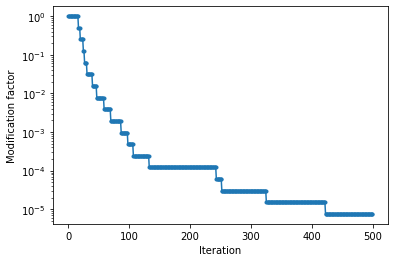

In [11]:
plt.semilogy(sampler.samples.get_trace_value("mod_factor"), '.-')
plt.xlabel("Iteration")
plt.ylabel("Modification factor")

### 5) Look at the estimated density of states

Once the Wang-Landau sampling has converged to an acceptable accuracy, we only need the very last value of the entropy to compute the DOS and resulting thermodynamic quantities

#### Density of states

Note: the computed DOS is not absolute so further calculations must be done accordingly. In our case we will normalize with the total number of states.

Also note: for the small system we are using we observe "wiggles" at high energy. Wiggles start to dissappear for larger systems.

In [12]:
# get entropy from the last trace, and energy levels from kernel
entropy = sampler.samples.get_trace_value("entropy")[-1]
energy_levels = sampler.mckernels[0].levels

# create a mask to remove zero entries (energy bins that were never visited)
mask = entropy > 0
entropy = entropy[mask]

Text(0, 0.5, 'density of states')

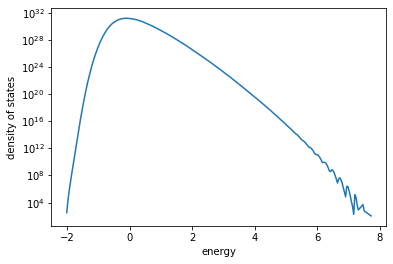

In [13]:
# re-reference to prevent possible overflow
entropy = entropy - entropy.min()
dos = np.exp(entropy - entropy.max()) / np.sum(np.exp(entropy - entropy.max()))

N = ensemble.num_sites
dos = dos * 2 ** N / np.sum(dos)  # set absolute reference

plt.semilogy(energy_levels / N, dos)
plt.xlabel("energy")
plt.ylabel("density of states")

### 5) Compute free energy, entropy and internal energy

With Wang-Landau sampling we have a direct estimate of the partition function as a function of temperature! So we can compute thermodynamic quantities directly from definition!

Text(0.5, 0, 'temperature')

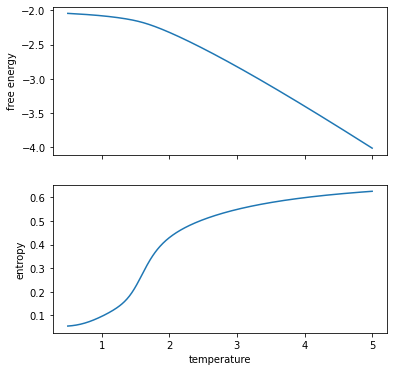

In [14]:
temperatures = np.linspace(0.5, 5, 500) # units of J

# rereference the energy to avoid overflow
E_rr = energy_levels - energy_levels.min()

# compute the partition function
Z = np.array([np.sum(dos * np.exp(-E_rr / T)) for T in temperatures])

# compute the free energy
F = - temperatures * np.log(Z) + energy_levels.min()

# compute internal energy
U = np.array(
        [np.sum(dos * energy_levels * np.exp(-E_rr / T))
         for T in temperatures]
    ) / Z

# compute canonical entropy
S = (U - F) / temperatures

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 6))
ax[0].plot(temperatures, F / N)
ax[1].plot(temperatures, S / N)


ax[0].set_ylabel("free energy")
ax[1].set_ylabel("entropy")

ax[1].set_xlabel("temperature")

### 5) Finally compute heat capacity, magnetization and susceptibility

The magnetization can be computed using the average correlation functions per energy. Heat capacity and susceptibility can then be computed from their variance definitions 

In [15]:
# compute heat capacity
U2 = np.array(
        [np.sum(dos * energy_levels ** 2 * np.exp(-E_rr / T))
         for T in temperatures]
    ) / Z
Cv = 1 / temperatures ** 2 * (U2 - U ** 2)

# compute magnetization and susceptibility
corrs = sampler.samples.get_trace_value("cumulative_mean_features")[-1][mask]
point_corrs = - corrs[:, 1]  # minus one to make magnetization p
M = np.array(
        [np.sum(dos * point_corrs * np.exp(-E_rr / T))
         for T in temperatures]
    ) / Z

M2 = np.array(
        [np.sum(dos * point_corrs ** 2 * np.exp(-E_rr / T))
         for T in temperatures]
    ) / Z

X = 1 / temperatures * (U2 - U ** 2)

Text(0, 0.5, 'susceptibility')

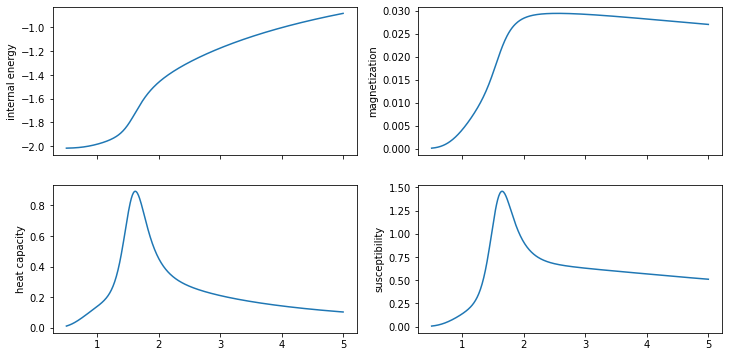

In [16]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 6))

ax[0, 0].plot(temperatures, U / N)
ax[0, 0].set_ylabel("internal energy")
ax[1, 0].plot(temperatures, Cv / N)
ax[1, 0].set_ylabel("heat capacity")

ax[0, 1].plot(temperatures, M / N)
ax[0, 1].set_ylabel("magnetization")
ax[1, 1].plot(temperatures, X / N)
ax[1, 1].set_ylabel("susceptibility")